# Feature Engineering on NFL Playoff Predictions 

This post is a part 2 from the NFL Playoff Bound Predictions. In the first post, we touched on feature engineering but in this notebook, we will delve deeper into feature analysis in order to confirm our inital assumption or refine how we can select better features to predict.

In [1]:
import pandas as pd  # data manipultion librabry
import numpy as np # numerical cmputation library

# Display up to 120 columns of a dataframe
pd.set_option('display.max_columns', 120)

import matplotlib.pyplot as plt  # plotting library
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
# sns.set(font_scale = 2)

# ML Imports
from sklearn.preprocessing import Imputer
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

from skll.metrics import spearman

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import warnings

In [2]:
team_df = pd.read_csv('nfl_team_stats.csv') 

In [3]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(12,9)})
RANDOM_STATE = 420
N_JOBS=8

In [4]:
# Split the data into train and test sets
train_df = team_df[team_df.TeamID.str.contains('2017') == False]
test_df = team_df[team_df.TeamID.str.contains('2017')  == True]

In [5]:


# Best Team Indicators to be Playoff Bound
features = ['Pass_O_Total_EPA',
 'Run_O_Win_Success_Rate',
 'Pass_O_Clutch_EPA_per_Drive',
 'Total_Success_Rate',
 'Pass_D_Win_Success_Rate',
 'Total_EPA',
 'Pass_O_Interceptions',
 'Pass_O_Success_Rate',
 'third_down_conv_rate1',
 'fourth_down_conv_rate']

# what to predict
target = 'playoffs'

X = train_df[features].values
y = train_df[target].values

# the modeling pipeline
pipe = Pipeline([("imputer", Imputer()),
                 ("estimator", RandomForestRegressor(random_state=RANDOM_STATE))])

To tune our model we will use BayesSearchCV from scikit-optimize, which utilizes bayesian optimization to find the best hyperparameters. We'll use Spearman's rank correlation as our scoring metric since we are mainly concerned with the ranking of teams when it comes to making the playoffs.

We tilize spearman's rank-order correlation as a scoring metric. Spearman is a nonparametric version of the Perason correlation. Spearmans correlation coefficient measures the strength and direction associated between two ranked variables. 

In [6]:
# We use spearman's rank correlation as the scoring metric since
# we are concerned with ranking the teams per the features to predict playoff bound
spearman_scorer = make_scorer(spearman)

# the hyperparamters to search over, including different imputation strategies
rf_param_space = {
    'imputer__strategy': Categorical(['mean', 'median', 'most_frequent']),
    'estimator__max_features': Integer(1, 8),
    'estimator__n_estimators': Integer(50, 500), 
    'estimator__min_samples_split': Integer(2, 200),
}
# create our search object
search = BayesSearchCV(pipe, 
                      rf_param_space, 
                      cv=10,
                      n_jobs=N_JOBS, 
                      verbose=0, 
                      error_score=-9999, 
                      scoring=spearman_scorer, 
                      random_state=RANDOM_STATE,
                      return_train_score=True, 
                      n_iter=75)
# fit the model
# I get some funky warnings, possibly due to the spearman scorer,
# I choose to suppress them
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    search.fit(X, y)

In [7]:
# best model parameters
search.best_params_

{'estimator__max_features': 1,
 'estimator__min_samples_split': 2,
 'estimator__n_estimators': 363,
 'imputer__strategy': 'mean'}

In [8]:
# CV score
search.best_score_

0.6312170661983129

In [9]:
# CV standard deviation
search.cv_results_['std_test_score'][search.best_index_]

0.09051314689993682

Now that we've tuned our model let's evaluate it on the test set.

In [10]:
# test set data
X_test = test_df[features].values
y_test = test_df[target].values
# predictions
y_pred = search.predict(X_test)
# evaluation
model_test_score = spearman_scorer(search, X_test, y_test)
model_test_score

0.6180982563844155

So our model's predictions had a Spearman's rank correlation of about 0.618 Is that good or bad? I'm not sure. To get a better sense of how good or how bad of a score that is we can use the actual playoff teams as a comparison point.

### Feature Importance

#### Mean Decrease Impurity
When using a tree-ensemble like random forest you can find out which features the model found valuable by checking the feature importances. In scikit-learn the feature importances are a reflection of how well a feature reduces some criterion. In our regression example that criterion is mean squared error. This method for calculating feature importance is typically called mean decrease impurity or gini importance.

We can access our model's feature importances with the feature_importances_ attribute.

In [11]:
# get the estimator and imputer from our pipeline, which will be used
# as we try and interpret our model
estimator = search.best_estimator_.named_steps['estimator']
imputer = search.best_estimator_.named_steps['imputer']

estimator.feature_importances_

array([0.10429083, 0.1153821 , 0.10764067, 0.08856305, 0.11806691,
       0.09794935, 0.11044838, 0.08724203, 0.07618143, 0.09423525])

Alternatively, we could use eli5's explain_weights_df function, which returns the importances and the feature names we pass it as a pandas DataFrame.

In [12]:
import eli5

# create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(estimator, feature_names=features)
feat_imp_df

,feature,weight,std
0,Pass_D_Win_Success_Rate,0.118067,0.070755
1,Run_O_Win_Success_Rate,0.115382,0.092851
2,Pass_O_Interceptions,0.110448,0.092499
3,Pass_O_Clutch_EPA_per_Drive,0.107641,0.090320
4,Pass_O_Total_EPA,0.104291,0.088151
5,Total_EPA,0.097949,0.084023
6,fourth_down_conv_rate,0.094235,0.065980
7,Total_Success_Rate,0.088563,0.065545
8,Pass_O_Success_Rate,0.087242,0.068289
9,third_down_conv_rate1,0.076181,0.047155


It looks like Pass_D_W and Run_O Win success rates are important to the model.  A thing to note is that explain_weights_df also returns the standard deviations, but they may not be trustworthy as those values assume a normal distribution. Instead of relying on those standard deviations we can access each tree in our ensemble and plot the full distribution of feature importances.


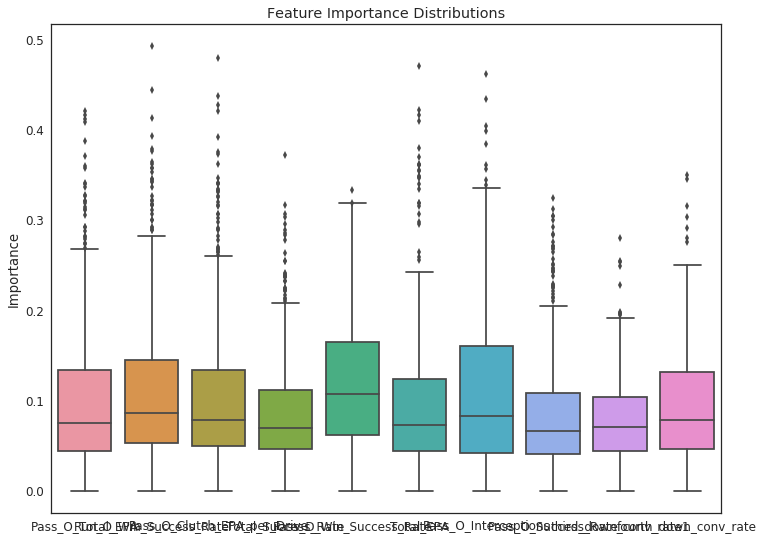

In [13]:
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=features)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

#### Permutation Importance

Permutation importances or mean decrease accuracy (MDA) is an alternative to mean decrease impurity that can be applied to any model. The basic idea of permutation importance is to permute the values of each feature and measure how much that permutation negatively impacts the scoring metric (which in our case is the Spearman's rank correlation). This gives us a sense of how our model would perform without that specific feature. All we need to do is calculate permutation importance is use PermutationImportance from eli5

In [14]:
from eli5.sklearn import PermutationImportance

# we need to impute the data first before calculating permutation importance
train_X_imp = imputer.transform(X)
# set up the met-estimator to calculate permutation importance on our training
# data
perm_train = PermutationImportance(estimator, scoring=spearman_scorer,
                                   n_iter=50, random_state=RANDOM_STATE)
# fit and see the permuation importances
perm_train.fit(train_X_imp, y)
eli5.explain_weights_df(perm_train, feature_names=features)

,feature,weight,std
0,Pass_D_Win_Success_Rate,0.012734,0.002961
1,Run_O_Win_Success_Rate,0.001947,0.001068
2,Pass_O_Interceptions,0.000595,0.000465
3,third_down_conv_rate1,0.000586,0.000325
4,fourth_down_conv_rate,0.000532,0.000478
5,Total_Success_Rate,0.000140,0.000134
6,Pass_O_Success_Rate,0.000048,0.000058
7,Pass_O_Clutch_EPA_per_Drive,0.000039,0.000042
8,Pass_O_Total_EPA,0.000026,0.000005
9,Total_EPA,0.000024,0.000004


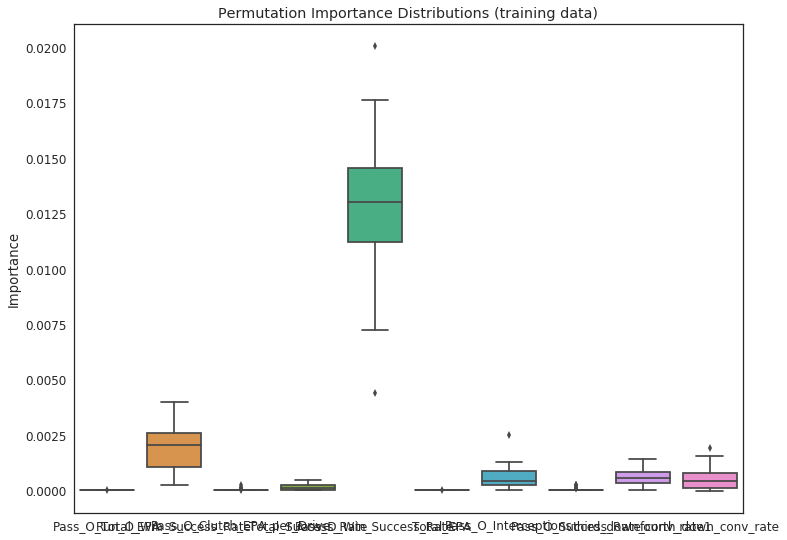

In [15]:
# plot the distributions
perm_train_feat_imp_df = pd.DataFrame(data=perm_train.results_,
                                      columns=features)
(sns.boxplot(data=perm_train_feat_imp_df)
        .set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'));

Based on the permutation importances we have some low importances, however, again Pass_D_ Win seems to be an important feature to model. 

### Resources

Here is a list of resources that I found helpful when writing up this post:

__General__
* [NFL Stats Reference](https://www.pro-football-reference.com/teams/dal/2017.htm)

__Feature Engineering__
* [Model Interpretability](https://github.com/savvastj/model_interpretability_post/blob/master/03_Model_Interpretability_Blog_Post.ipynb)
* [Random Forest Intepretation with Scikit Learn](http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/)


__Model Implementation and Anlysis__
* [Sklearn Metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Brest Cancer Prediction](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/breast_cancer_predict.ipynb)